In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.distributions as dist

import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
from pyro.distributions import Distribution

import sys
import os

#Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from Base.utilities import *
from scipy.interpolate import griddata, interp2d

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Elliptic 2D

$$-\nabla \cdot (a(x,\theta)\nabla u(x,\theta)) = 4x_{1}x_{2}, \quad x\in (0,1)^{2},\theta \in [-\sqrt(3),\sqrt(3)]^{N}$$
$$u(x) = 0 \quad x \in \partial D$$

where $a(x,\theta)$ has the following form:
 
$$  
a(x,\theta) = \mu_{a}  +  \sum_{i,j=1}^{k_{i}, k_{j}} \sqrt a_{i,j} \theta_{i,j} b_{i,j}(x)  
$$

where $a_{n} = \frac{1}{4}\exp(- \pi (i^{2}+ j^{2})l^{2})$ and $b_{i,j} = 2 \cos(i \pi x_{1})\cos(j \pi x_{2})$.

In [38]:
def compute_seq_pairsb(N_KL, include_00=True):
    trunc_Nx = int(np.floor(np.sqrt(2 * N_KL)) + 1)

    # Create grid of i and j
    i_vals = np.arange(trunc_Nx)
    j_vals = np.arange(trunc_Nx)
    ii, jj = np.meshgrid(i_vals, j_vals, indexing='ij')
    ii = ii.ravel()
    jj = jj.ravel()

    if not include_00:
        mask = ~((ii == 0) & (jj == 0))
        ii = ii[mask]
        jj = jj[mask]

    norms = ii**2 + jj**2
    idx = np.argsort(norms)[:N_KL]
    return np.stack([ii[idx], jj[idx]], axis=1)

def compute_seq_pairs(N_KL, include_00=True):
    trunc_Nx = int(np.floor(np.sqrt(2 * N_KL)) + 1)
    pairs = []
    # Generate (i, j) pairs and their squared norms
    for i in range(trunc_Nx):
        for j in range(trunc_Nx):
            if i == 0 and j == 0 and not include_00:
                continue
            pairs.append([i, j, i**2 + j**2])

    # Sort pairs by the squared norm (third column) and select the first N_KL pairs
    pairs = sorted(pairs, key=lambda x: x[2])[:N_KL]
    
    # Return only the (i, j) pairs, discarding the norm
    return np.array(pairs)[:, :2]

s = compute_seq_pairs(100)
sb = compute_seq_pairsb(100)

print(s)


[[ 0  0]
 [ 0  1]
 [ 1  0]
 [ 1  1]
 [ 0  2]
 [ 2  0]
 [ 1  2]
 [ 2  1]
 [ 2  2]
 [ 0  3]
 [ 3  0]
 [ 1  3]
 [ 3  1]
 [ 2  3]
 [ 3  2]
 [ 0  4]
 [ 4  0]
 [ 1  4]
 [ 4  1]
 [ 3  3]
 [ 2  4]
 [ 4  2]
 [ 0  5]
 [ 3  4]
 [ 4  3]
 [ 5  0]
 [ 1  5]
 [ 5  1]
 [ 2  5]
 [ 5  2]
 [ 4  4]
 [ 3  5]
 [ 5  3]
 [ 0  6]
 [ 6  0]
 [ 1  6]
 [ 6  1]
 [ 2  6]
 [ 6  2]
 [ 4  5]
 [ 5  4]
 [ 3  6]
 [ 6  3]
 [ 0  7]
 [ 7  0]
 [ 1  7]
 [ 5  5]
 [ 7  1]
 [ 4  6]
 [ 6  4]
 [ 2  7]
 [ 7  2]
 [ 3  7]
 [ 7  3]
 [ 5  6]
 [ 6  5]
 [ 0  8]
 [ 8  0]
 [ 1  8]
 [ 4  7]
 [ 7  4]
 [ 8  1]
 [ 2  8]
 [ 8  2]
 [ 6  6]
 [ 3  8]
 [ 8  3]
 [ 5  7]
 [ 7  5]
 [ 4  8]
 [ 8  4]
 [ 0  9]
 [ 9  0]
 [ 1  9]
 [ 9  1]
 [ 2  9]
 [ 6  7]
 [ 7  6]
 [ 9  2]
 [ 5  8]
 [ 8  5]
 [ 3  9]
 [ 9  3]
 [ 4  9]
 [ 9  4]
 [ 7  7]
 [ 0 10]
 [ 6  8]
 [ 8  6]
 [10  0]
 [ 1 10]
 [10  1]
 [ 2 10]
 [10  2]
 [ 5  9]
 [ 9  5]
 [ 3 10]
 [10  3]
 [ 7  8]
 [ 8  7]]


4.08418760895713


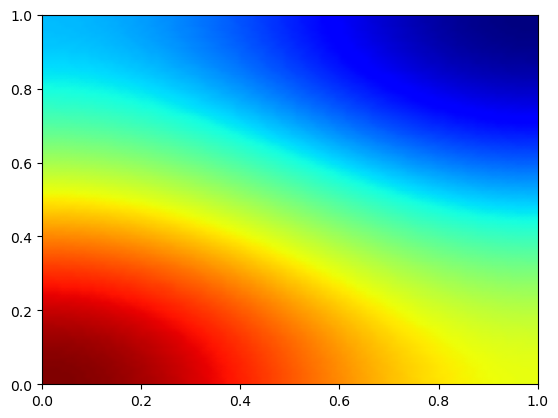

In [39]:
x = np.linspace(0,1,100)
l = 1

X,Y = np.meshgrid(x,x)

#rng = np.random.default_rng(0)
rng = np.random
theta = rng.uniform(low = -np.sqrt(3),high = np.sqrt(3),size=100)

def field_generator(theta, X,Y,l = 1., mean = 5):
    n_terms = theta.shape[-1]
    eigen_pairs = compute_seq_pairs(n_terms)
    a_x = mean
    for i, (kx, ky) in enumerate(eigen_pairs):
        v_ij = np.exp(-np.pi*(kx**2 + ky**2)*l**2)/4
        phi_ij = 2*np.cos(kx*np.pi*X)*np.cos(ky*np.pi*Y)
        a_x += np.sqrt(v_ij)*phi_ij*theta[i]

    return a_x




a_x = field_generator(theta,X,Y)
print(np.min(a_x))



plt.pcolormesh(X, Y, a_x, shading="gouraud", cmap = "jet")

In [17]:
import ufl
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import mesh, fem, plot
from dolfinx.fem.petsc import LinearProblem
from dolfinx import geometry
from scipy.optimize import fsolve, brentq

def compute_seq_pairs(N_KL, include_00=False):
    trunc_Nx = int(np.floor(np.sqrt(2 * N_KL)) + 1)
    pairs = []
    # Generate (i, j) pairs and their squared norms
    for i in range(trunc_Nx):
        for j in range(trunc_Nx):
            if i == 0 and j == 0 and not include_00:
                continue
            pairs.append([i, j, i**2 + j**2])

    # Sort pairs by the squared norm (third column) and select the first N_KL pairs
    pairs = sorted(pairs, key=lambda x: x[2])[:N_KL]
    
    # Return only the (i, j) pairs, discarding the norm
    return np.array(pairs)[:, :2]


class RootFinder:
    def __init__(self, lam , M, equation=None):
        """
        lam: parameter lambda (for your equation)
        M: number of intervals to search for roots
        equation: optional, if you want to provide a custom equation
        """
        self.lam = lam
        self.M = M
        self.c = 1 / lam
        self.equation = equation if equation else self.default_equation

    def default_equation(self, x):
        """Default transcendental equation: tan(x) = (2c*x)/(x^2 - c^2)"""
        c = self.c
        return np.tan(x) - (2 * c * x) / (x**2 - c**2)

    def find_roots(self):
            """Find the roots using the Brent or fsolve method depending on the case."""
            roots = []
            for i in range(self.M):
                wmin = (i - 0.499) * np.pi
                wmax = (i + 0.499) * np.pi

                # Handle the singularity around c
                if wmin <= self.c <= wmax:  
                    if wmin > 0:
                        root = fsolve(self.equation, (self.c + wmin) / 2)[0]
                        roots.append(root)
                    root = fsolve(self.equation, (self.c + wmax) / 2)[0]
                    roots.append(root)
                elif wmin > 0:  
                    root = brentq(self.equation, wmin, wmax)
                    roots.append(root)
            
            return np.array(roots)

# class Parametric_K:
#     def __init__(self, theta, l, mean):
#         self.theta = np.array(theta)
#         self.l = l
#         self.mean = np.array(mean)
#         self.eigen_pairs = compute_seq_pairs(theta.shape[-1])

#     def eval(self, x, y):
#         """
#         Evaluate the sum for a given x, summing over all terms defined by theta and roots.
#         x: 2D array of points (n, dim), where n is the number of points and dim is the dimension.
#         Returns an array of evaluations for each point.
#         """
#         result = np.zeros(x.shape[0])
#         # Initialize the result array (same size as the number of points)
#         for i, (kx, ky) in enumerate(self.eigen_pairs):
#             v_ij = np.exp(-np.pi * (kx**2 + ky**2) * self.l**2) / 4
#             phi_ij = 2 * np.cos(kx * np.pi * x) * np.cos(ky * np.pi * y)
#             result += np.sqrt(v_ij) * phi_ij * self.theta[i]
#         #print(np.min(result + self.mean))
#         return result + self.mean

# class Parametric_K:
#     def __init__(self, theta, lam =1/4):
#         self.theta = np.array(theta)
#         self.M = theta.shape[-1]
#         self.trunc_Nx = int(np.ceil(0.5*self.M + 1))
#         #self.eigen_pairs = compute_seq_pairs(self.M ,include_00=True)
#         self.finder = RootFinder(lam,self.trunc_Nx )
#         self.roots = np.array(self.finder.find_roots())

#     @property
#     def A(self):
#         """Compute the A coefficients."""
#         return np.sqrt(1 / ((1/8)*(5 + (self.roots / 2)**2) + 
#                             (np.sin(2*self.roots) / (4*self.roots)) * ((self.roots / 4)**2 - 1) - (np.cos(2*self.roots)/8)))
#     @property
#     def an(self):
#         """Compute the an values."""
#         return np.sqrt(8 / (self.roots**2 + 16))
#     @property
#     def k_terms_order(self):
#         v_ij = np.outer(self.an, self.an).ravel()
#         indices = np.array([(i, j) for i in range(self.trunc_Nx) for j in range(self.trunc_Nx)])
#         sort_idx = np.argsort(v_ij)[::-1]
#         v_ij,indices = v_ij[sort_idx],indices[sort_idx]
#         v_ij,indices = v_ij[:self.M],indices[:self.M]
#         kx,ky = indices[:, 0],indices[:, 1]
#         A_x, roots_x = self.A[kx],self.roots[kx]
#         A_y, roots_y = self.A[ky],self.roots[ky]
#         return v_ij[:,None],A_x[:,None],A_y[:,None],roots_x[:,None],roots_y[:,None]
    
#     def eval(self,x,y):
#         v_ij,A_x,A_y,roots_x,roots_y = self.k_terms_order

#         phi_i = A_x* (np.sin(roots_x * x[None,:]) + (roots_x/ 4) * np.cos(roots_x * x[None,:]))
#         phi_j = A_y * (np.sin(roots_y * y[None,:]) + (roots_y / 4) * np.cos(roots_y* y[None,:]))

#         v_phi_theta= np.sum(phi_i*phi_j*v_ij*self.theta[:,None], axis=0)

#         return np.exp(v_phi_theta)



class Parametric_K:
    def __init__(self, theta, lam =1/4):
        self.theta = np.array(theta)
        self.M = theta.shape[-1]
        self.trunc_Nx = int(np.ceil(0.5*self.M + 1))
        #self.eigen_pairs = compute_seq_pairs(self.M )
        self.finder = RootFinder(lam,self.trunc_Nx)
        self.roots = np.array(self.finder.find_roots())

    @property
    def A(self):
        """Compute the A coefficients."""
        return np.sqrt(1 / ((1/8)*(5 + (self.roots / 2)**2) + 
                            (np.sin(2*self.roots) / (4*self.roots)) * ((self.roots / 4)**2 - 1) - (np.cos(2*self.roots)/8)))
    @property
    def an(self):
        """Compute the an values."""
        return np.sqrt(8 / (self.roots**2 + 16))
    
    @property
    def k_terms_order(self):
        v_ij = np.outer(self.an, self.an).ravel()
        indices = np.array([(i, j) for i in range(self.trunc_Nx) for j in range(self.trunc_Nx)])
        sort_idx = np.argsort(np.array(v_ij))[::-1].copy()
        #sort_idx =torch.tensor()
        v_ij,indices = v_ij[sort_idx],indices[sort_idx]
        v_ij,indices = v_ij[:self.M],indices[:self.M]
        kx,ky = indices[:, 0],indices[:, 1]
        A_x, roots_x = self.A[kx],self.roots[kx]
        A_y, roots_y = self.A[ky],self.roots[ky]

        return v_ij,A_x,A_y,roots_x,roots_y
    
    def eval(self,x,y):
        v_ij,A_x,A_y,roots_x,roots_y = self.k_terms_order
        phi_i = A_x[:,None] * (np.sin(roots_x[:,None] * x[None, :]) + (roots_x[:,None] / 4) * np.cos(roots_x[:,None] * x[None, :]))
        phi_j = A_y[:,None] * (np.sin(roots_y[:,None] * y[None, :]) + (roots_y[:,None] / 4) * np.cos(roots_y[:,None] * y[None, :]))
        v_phi_theta = np.sum(v_ij[:,None]*phi_i*phi_j*self.theta[:,None],axis=0)
        return np.exp(v_phi_theta)
    
    
    # @property
    # def an_2(self):
    #     v_ij = np.outer(self.an, self.an).ravel()
    #     indices = np.array([(i, j) for i in range(self.trunc_Nx) for j in range(self.trunc_Nx)])
    #     sort_idx = np.argsort(v_ij)[::-1]
    #     v_ij,indices = v_ij[sort_idx],indices[sort_idx]
    #     return v_ij[:self.M],indices[:self.M]
    
    # def eval3(self, x,y):
    #     vij,indices = self.an_2
    #     result = np.zeros(x.shape[0])
    #     for i, (kx, ky) in enumerate(indices):
    #         phi_i = self.A[kx] * (np.sin(self.roots[kx] * x) + (self.roots[kx] / 4) * np.cos(self.roots[kx] * x))
    #         phi_j = self.A[ky] * (np.sin(self.roots[ky] * y) + (self.roots[ky] / 4) * np.cos(self.roots[ky] * y))
    #         result += self.theta[i] * vij[i] * phi_i*phi_j
    #     return np.exp(result)


    # def eval2(self, x,y):
    #     """
    #     Evaluate the sum for a given x, summing over all terms defined by theta and roots.
    #     x: 2D array of points (n, dim), where n is the number of points and dim is the dimension.
    #     Returns an array of evaluations for each point.
    #     """
    #     # Initialize the rthetaesult array (same size as the number of points)
    #     result = np.zeros(x.shape[0])
    #     eigen = []
    
    #     # Compute the sum over all terms
    #     for i, (kx, ky) in enumerate(self.eigen_pairs):
    #         v_ij = self.an[kx] *self.an[ky]
    #         phi_i = self.A[kx] * (np.sin(self.roots[kx] * x) + (self.roots[kx] / 4) * np.cos(self.roots[kx] * x))
    #         phi_j = self.A[ky] * (np.sin(self.roots[ky] * y) + (self.roots[ky] / 4) * np.cos(self.roots[ky] * y))
    #         eigen.append(v_ij)
    #         result += self.theta[i] * v_ij * phi_i*phi_j
    #     return np.exp(result),eigen
    

    

    
# domain = mesh.create_unit_square(MPI.COMM_WORLD, nx =100, ny = 100,cell_type=mesh.CellType.triangle )
# V = fem.functionspace(domain, ("Lagrange", 1))
# rng = np.random

# theta = rng.uniform(low = -np.sqrt(3),high = np.sqrt(3),size=100)

# k = fem.Function(V)
# k_an = Parametric_K(theta)
# x = np.linspace(0,1,100)
# l = 1

# X,Y = np.meshgrid(x,x)

# a_x = field_generator(theta,X,Y)

# pcm = plt.pcolormesh(X, Y, a_x, shading="gouraud", cmap="jet")
# plt.colorbar(pcm)  # Add colorbar based on the plot

# k.interpolate(lambda x: k_an.eval(x[0], x[1]))


# import pyvista

# cells, types, x = plot.vtk_mesh(V)
# grid = pyvista.UnstructuredGrid(cells, types, x)

# # k.x.array contains the DOFs values at mesh vertices
# # It’s 1D since k is scalar; reshape it for PyVista
# values = k.x.array.real

# # Attach the scalar function values to the mesh points
# grid.point_data["k"] = values

# pl = pyvista.Plotter()
# pl.add_text("Scalar field k", font_size=12, color="black", position="upper_edge")
# pl.add_mesh(grid.copy(), show_edges=True, scalars="k", cmap="viridis")
# pl.view_xy()


# pl.show()

# N = 128
# xgrid = np.linspace(0,1,N)
# X, Y = np.meshgrid(xgrid, xgrid)

# seed = 42  # Base seed for reproducibility
# rng = np.random.default_rng(seed)
# theta = rng.uniform(low = -1,high = 1,size=20)

# k = Parametric_K(theta=theta)
# a_x = k.eval(X.ravel(),Y.ravel())
# b_x,z = k.eval2(X.ravel(),Y.ravel())
# x,y = X.ravel(),Y.ravel()
# x_dim = x.shape[0]
# v_ij = np.outer(k.an, k.an)
# phi_i = k.A[:,None] * (np.sin(k.roots[:,None] * x[None, :]) + (k.roots[:,None] / 4) * np.cos(k.roots[:,None] * x[None, :]))
# phi_j = k.A[:,None] * (np.sin(k.roots[:,None] * y[None, :]) + (k.roots[:,None] / 4) * np.cos(k.roots[:,None] * y[None, :]))

# v_ij = v_ij.ravel()        # (10000,)
# sort_idx = np.argsort(v_ij)[::-1]
# v_ij = v_ij[sort_idx]

# phi_ij= phi_i[:, None, :] * phi_j[None, :, :]  # (100, 100, 16000)
# phi_ij = phi_ij.reshape(-1, x_dim)
# phi_ij = phi_ij[sort_idx, :]


# np.exp(np.sum(phi_ij[:k.M,:]*v_ij[:k.M,None]*k.theta[:,None],axis=0))
# #v_phi_theta= np.sum(phi_ij[:self.M,:]*v_ij[:self.M,None]*self.theta[:,None], axis=0)


# plt.plot(vij)
# plt.plot(z)

In [18]:
from elliptic2d_files.elliptic2d import Elliptic2D
from ml_collections import ConfigDict


def elliptic2d_experiment():
    config = ConfigDict()
    config.verbose = False

    # NN training config
    config.train = False

    # Weights & Biases
    config.wandb = ConfigDict()
    config.wandb.project = "Elliptic2D-IP"
    config.wandb.name = "MDNN"
    config.wandb.tag = None

    # Model settings
    config.nn_model = "MDNN"
    config.lambdas = {"elliptic": 1, "ubcl": 1, "ubcr": 1,"ubcd":1,"ubcu":1}
    config.model = ConfigDict()
    config.model.input_dim = 4
    config.model.hidden_dim = 100
    config.model.num_layers = 3
    config.model.out_dim = 1
    config.model.activation = "tanh"
    config.KL_expansion = 5000

    # Periodic embeddings
    #config.model.period_emb = ConfigDict({"period":(1.0, 1.0), "axis":(0, 1) })

    # Fourier embeddings
    config.model.fourier_emb = ConfigDict({"embed_scale":1,"embed_dim":100,"exclude_last_n":2})

    # Training settings
    config.seed = 42
    config.learning_rate = 0.001
    config.decay_rate = 0.95
    config.epochs = 5_000
    config.start_scheduler = 0.5
    config.scheduler_step = 50
    config.nn_samples = 400
    config.batch_size = 250

    return config

config_experiment = elliptic2d_experiment()

N = 50
xgrid = np.linspace(0,1,N)
X, Y = np.meshgrid(xgrid, xgrid)
seed = 0  # Base seed for reproducibility
rng = np.random.default_rng(seed)
theta = rng.uniform(low = -1,high = 1,size=config_experiment.KL_expansion)


fgenerator = Parametric_K(theta)
a_x = fgenerator.eval(X.ravel(),Y.ravel())
#a_xx = fgenerator.eval3(X.ravel(),Y.ravel())

a_x = griddata((X.reshape(-1), Y.reshape(-1)), a_x,
                (X, Y), method='cubic')
torch.set_default_dtype(torch.float64)

dg_elliptic = Elliptic2D(config=config_experiment, device=device)

points = torch.tensor(np.column_stack((X.ravel(), Y.ravel())), dtype=torch.float64)

th =torch.tensor( theta.reshape(1,-1))
data = torch.cat([points, th.repeat(points.shape[0], 1)], dim=1).float()

a_nn_x = dg_elliptic.k_function(data)
# a_nn_xx= dg_elliptic.k_function2(data)

a_nn_x = griddata((X.reshape(-1), Y.reshape(-1)), a_nn_x.flatten(),
                (X, Y), method='cubic')

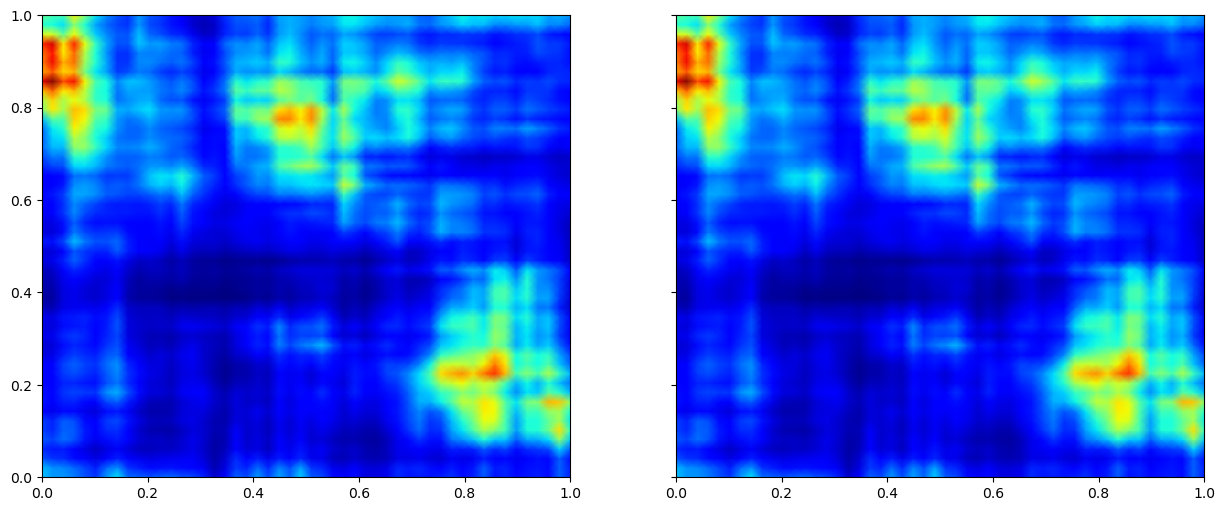

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15, 6), sharex=True, sharey=True)

pcm = axs[0].pcolormesh(X, Y, a_x, shading="gouraud", cmap="jet")
pcm = axs[1].pcolormesh(X, Y, np.exp(a_nn_x), shading="gouraud", cmap="jet")


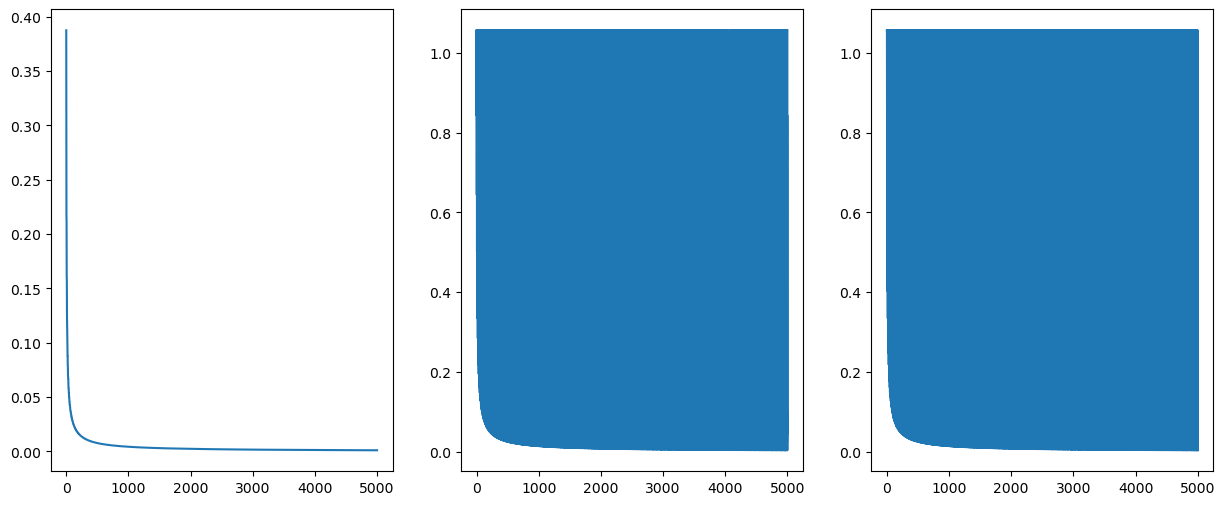

In [20]:
v_ij,A_kx,A_ky,roots_kx,roots_ky = dg_elliptic.k_terms_order

fig, axs = plt.subplots(1,3, figsize=(15, 6))

axs[0].plot(v_ij)
axs[1].plot(A_kx)
axs[2].plot(A_ky)


In [53]:
import numpy as np


class RootFinder:
    def __init__(self, lam , M, equation=None):
        """
        lam: parameter lambda (for your equation)
        M: number of intervals to search for roots
        equation: optional, if you want to provide a custom equation
        """
        self.lam = lam
        self.M = M
        self.c = 1 / lam
        self.equation = equation if equation else self.default_equation

    def default_equation(self, x):
        """Default transcendental equation: tan(x) = (2c*x)/(x^2 - c^2)"""
        c = self.c
        return np.tan(x) - (2 * c * x) / (x**2 - c**2)

    def find_roots(self):
            """Find the roots using the Brent or fsolve method depending on the case."""
            roots = []
            for i in range(self.M):
                wmin = (i - 0.499) * np.pi
                wmax = (i + 0.499) * np.pi

                # Handle the singularity around c
                if wmin <= self.c <= wmax:  
                    if wmin > 0:
                        root = fsolve(self.equation, (self.c + wmin) / 2)[0]
                        roots.append(root)
                    root = fsolve(self.equation, (self.c + wmax) / 2)[0]
                    roots.append(root)
                elif wmin > 0:  
                    root = brentq(self.equation, wmin, wmax)
                    roots.append(root)
            
            return np.array(roots)

def f(omega, lam, x):
    """Helper function for KL expansion eigenfunctions."""
    norm = 1.0 / np.sqrt(
        np.sin(2 * omega) * (0.25 * (lam**2 * omega - 1.0 / omega))
        - 0.5 * lam * np.cos(2 * omega)
        + 0.5 * (1 + lam + lam**2 * omega**2)
    )
    return norm * (np.sin(x * omega) + lam * omega * np.cos(x * omega))


def klsetup(lam, sigma2, mkl, h, roots_fn):
    """
    1D KL expansion setup.

    Parameters
    ----------
    lam : float
        Correlation length.
    sigma2 : float
        Variance of log(k).
    mkl : int
        Number of KL terms.
    h : float
        Mesh size.
    roots_fn : callable
        Function that returns the first mkl roots for the given lam.

    Returns
    -------
    A : ndarray
        Matrix mapping KL coefficients to field values.
    """
    c = 1.0 / lam
    omega = roots_fn(lam, mkl)  # must return shape (mkl,)
    eigvals = 2 * sigma2 * c / (omega**2 + c**2)

    x_vals = np.arange(0.5 * h, 1.0, h)
    A = np.zeros((len(x_vals), mkl))
    for i, x in enumerate(x_vals):
        eigfcts = f(omega, lam, x)
        A[i, :] = np.sqrt(eigvals) * eigfcts

    return A


def klsetup2DFE(lam, sigma2, mkl, h):
    """
    2D KL expansion setup for finite elements.

    Parameters
    ----------
    lam : float
        Correlation length.
    sigma2 : float
        Variance of log(k).
    mkl : int
        Number of KL terms (in 2D).
    h : float
        Mesh size.
    roots_fn : callable
        Function that returns the first N roots for the given lam.

    Returns
    -------
    A : ndarray
        Matrix mapping KL coefficients to 2D field values.
    """
    m = int(1.0 / h)
    c = 1.0 / lam
    mkl1 = int(np.ceil(0.5 * mkl + 1))

    A = np.zeros(((m + 1) ** 2, mkl))
    eigfcts = np.zeros((mkl1, m + 1))
    roots_fn = RootFinder(lam, mkl1)
    omega = roots_fn.find_roots()
    eigvals1D = 2 * c / (omega**2 + c**2)

    eigvals2D = np.outer(eigvals1D, eigvals1D)
    eigvec2D = eigvals2D.ravel(order="F")  # column-major like MATLAB

    index = np.argsort(eigvec2D)[::-1]  # descending
    eigvals = sigma2 * eigvec2D[index[:mkl]]

    for i in range(m + 1):
        x = i * h
        eigfcts[:, i] = f(omega, lam, x)

    for k in range(mkl):
        indexi = int(np.ceil((index[k] + 1) / mkl1))
        indexj = index[k] - (indexi - 1) * mkl1 + 1
        for i in range(m + 1):
            for j in range(m + 1):
                A[(j) * (m + 1) + i, k] = (#np.sqrt(eigvals[k])
                    1* eigfcts[indexi - 1, i]
                    * eigfcts[indexj - 1, j]
                    
                )
                print(omega[indexi-1],omega[indexj-1])


    return np.sqrt(eigvals), A

eigvals,A = klsetup2DFE(1/4, 1, 100, 1)
A

2.1537479726236093 2.1537479726236093
2.1537479726236093 2.1537479726236093
2.1537479726236093 2.1537479726236093
2.1537479726236093 2.1537479726236093
4.577859456206808 2.1537479726236093
4.577859456206808 2.1537479726236093
4.577859456206808 2.1537479726236093
4.577859456206808 2.1537479726236093
2.1537479726236093 4.577859456206808
2.1537479726236093 4.577859456206808
2.1537479726236093 4.577859456206808
2.1537479726236093 4.577859456206808
4.577859456206808 4.577859456206808
4.577859456206808 4.577859456206808
4.577859456206808 4.577859456206808
4.577859456206808 4.577859456206808
2.1537479726236093 7.287194334850801
2.1537479726236093 7.287194334850801
2.1537479726236093 7.287194334850801
2.1537479726236093 7.287194334850801
7.287194334850801 2.1537479726236093
7.287194334850801 2.1537479726236093
7.287194334850801 2.1537479726236093
7.287194334850801 2.1537479726236093
2.1537479726236093 10.17397018820454
2.1537479726236093 10.17397018820454
2.1537479726236093 10.17397018820454
2

array([[ 0.32394219,  0.54955799,  0.54955799,  0.93230828,  0.66799452,
         0.66799452,  0.72521647,  0.72521647,  1.13323222,  1.13323222,
         0.75431658,  0.75431658,  1.2303075 ,  1.2303075 ,  1.37745776,
         0.7704238 ,  0.7704238 ,  1.27967495,  1.27967495,  0.78007093,
         0.78007093,  1.49545395,  1.49545395,  1.30700035,  1.30700035,
         0.78623888,  0.78623888,  1.5554607 ,  1.5554607 ,  0.79039606,
         0.79039606,  1.62355796,  1.32336641,  1.32336641,  0.79332025,
         0.79332025,  1.33383016,  1.33383016,  1.58867506,  1.58867506,
         0.79545031,  0.79545031,  1.68870503,  1.68870503,  1.34088267,
         1.34088267,  0.79704751,  0.79704751,  1.60856821,  1.60856821,
         0.79827463,  0.79827463,  1.34584347,  1.34584347,  1.72476461,
         1.72476461,  0.79923711,  0.79923711,  1.62128702,  1.62128702,
         1.7564662 ,  1.34945705,  1.34945705,  0.80000552,  0.80000552,
         1.35216666,  1.35216666,  1.62985944,  1.6

In [21]:

class Elliptic2D:
    def __init__(self, theta, ncells=10):
        self.theta = theta

        self.domain = mesh.create_unit_square(MPI.COMM_WORLD, nx =ncells, ny = ncells,cell_type=mesh.CellType.triangle )
        self.V = fem.functionspace(self.domain, ("Lagrange", 1))
        self.bc = self.set_boundary_conditions()
        self.k = self.interpolate_k()
        self.f = self.interpolate_f()
        self.uh = None
    
    
    def interpolate_k(self):
        """Interpolate the k function based on the provided equation."""
        k = fem.Function(self.V)
        #k_an = Parametric_K(self.theta, l=self.l, mean=self.mean)
        k_an = Parametric_K(self.theta)
        k.interpolate(lambda x: k_an.eval(x[0], x[1]))
        return k
    
    def interpolate_f(self):
        """Interpolate the f function."""
        f = fem.Function(self.V)
        f.interpolate(lambda x: 4 * (x[0]*x[1]))
        return f

    def set_boundary_conditions(self):
        facets = mesh.locate_entities_boundary(self.domain, self.domain.topology.dim - 1,
                marker=lambda x: np.isclose(x[0], 0) | np.isclose(x[0], 1) | np.isclose(x[1], 0) | np.isclose(x[1], 1), )

        dofs = fem.locate_dofs_topological(V=self.V, entity_dim=1, entities=facets)
        # DirichletBC on all boundary
        bc = fem.dirichletbc(value=fem.Constant(self.domain, 0.0), dofs=dofs, V=self.V)
        return [bc]


    def solve(self):
        """Define and solve the linear variational problem."""
        # Interpolate k and f functions every time we solve
        self.k = self.interpolate_k()  # Ensure k is updated based on current theta
        self.f = self.interpolate_f()  # f can remain static, but can be updated if needed

        u = ufl.TrialFunction(self.V)
        v = ufl.TestFunction(self.V)

        # Define the bilinear form (a) and the linear form (L)
        a = self.k * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
        L = self.f *v * ufl.dx

        # Solve the linear problem
        problem = LinearProblem(a, L, bcs=self.bc)
        self.uh = problem.solve()
        return self.uh
    
    def solution_array(self):
        cells, types, x = plot.vtk_mesh(self.V)
        return (x, self.uh.x.array)
    
    def evaluate_at_points(self, points):
        """
        Evaluate the current and initial vorticity fields at specified points.
        """
        # Check if points array has correct shape
        if points.ndim != 2 or points.shape[1] != 3:
            raise ValueError(f"Points array must have shape (N, 3). Provided shape: {points.shape}")

        # Build the bounding box tree for the mesh
        bb_tree = geometry.bb_tree(self.domain, self.domain.topology.dim)

        # Find cells whose bounding boxes collide with the points
        cell_candidates = geometry.compute_collisions_points(bb_tree, points)

        # Compute colliding cells
        colliding_cells = geometry.compute_colliding_cells(self.domain, cell_candidates, points)

        # Store points and their corresponding cells
        cells = []
        points_on_proc = []

        for i, point in enumerate(points):
            if len(colliding_cells.links(i)) > 0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])  # Select the first colliding cell

        points_on_proc = np.array(points_on_proc, dtype=np.float64)

        if len(points_on_proc) > 0:
            # Evaluate `w` (current vorticity) and `w0` (initial vorticity) at the points
            u_values = self.uh.eval(points_on_proc, cells)
            return u_values
        else:
            raise ValueError("No points found on this process for evaluation.")

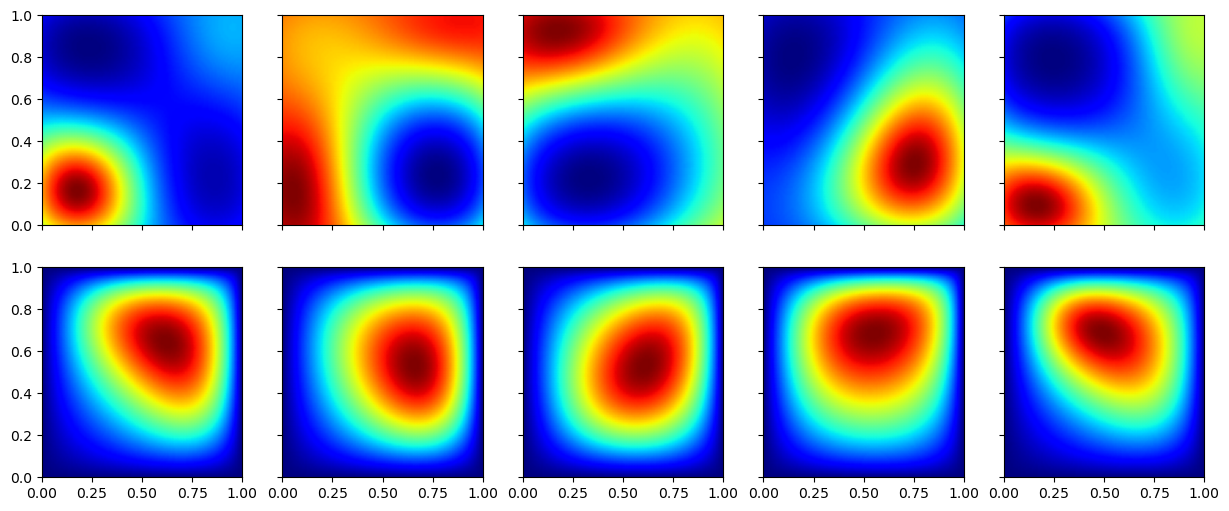

In [27]:
#rng = np.random.default_rng(0)
rng = np.random
N = 128
xgrid = np.linspace(0,1,N)
X, Y = np.meshgrid(xgrid, xgrid)

theta = rng.uniform(low = -np.sqrt(3),high = np.sqrt(3),size=(5,4))
#print(theta)
solver = Elliptic2D(theta=theta[0,:],ncells=50)

fig, axs = plt.subplots(2,5, figsize=(15, 6), sharex=True, sharey=True)

for i, th in enumerate(theta):
    solver.theta = th
    solver.solve()

    points = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)

    u_values =  solver.evaluate_at_points(points)

    z_pred = griddata((X.reshape(-1), Y.reshape(-1)), u_values.flatten(),
                    (X, Y), method='cubic')

    fgenerator = Parametric_K(th)
    a_x = fgenerator.eval(X.ravel(),Y.ravel())

    a_x = griddata((X.reshape(-1), Y.reshape(-1)), a_x,
                    (X, Y), method='cubic')

    pcm = axs[0,i].pcolormesh(X, Y, a_x, shading="gouraud", cmap="jet")
    #plt.colorbar(pcm)  # Add colorbar based on the plot

    pcm =axs[1,i].pcolormesh(X, Y, z_pred, shading="gouraud", cmap = "jet")
    #plt.colorbar(pcm)  # Add colorbar based on the plot


In [28]:
X = np.linspace(0, 1, 128)  # Spatial grid in X direction
Y = np.linspace(0, 1, 128)  # Spatial grid in Y direction
X, Y = np.meshgrid(X, Y)  # Create meshgrid for X, Y
n_samples = 4  # Number of samples you want to generate
seed = 42  # Base seed for reproducibility
N_KL = 10000

#rng = np.random.default_rng(seed)
rng = np.random
theta = rng.uniform(low = -1,high = 1,size=(n_samples,N_KL))

sum_elements = [100,200,300,500,600,800,900,1000,2000,3000,4000,5000]
#sum_elements = [500, 800, 1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000]
solution_list = {"coef":[],"sol":[]}


for teta in sum_elements:
    #theta_ = theta[-1,:teta]
    theta_ = np.ones(teta)
    # solver = Elliptic2D(theta=theta_)
    # solver.solve()

    k = Parametric_K(theta=theta_)
    a_x = k.eval(X.ravel(),Y.ravel())

    #a_x = field_generator(theta_,X,Y,l=l,mean=mean)

    solution_list["coef"].append(a_x)

    # points = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)

    # u_values =  solver.evaluate_at_points(points)

    # z_pred = griddata((X.reshape(-1), Y.reshape(-1)), u_values.flatten(),(X, Y), method='cubic')

    # solution_list["sol"].append(z_pred)

In [29]:
error_sol = {"coef":[],"sol":[]}

for i in range(0,len(sum_elements)-1):
    relterm = np.linalg.norm(solution_list["coef"][-1],ord = 2)
    error_sol["coef"].append(np.linalg.norm(solution_list["coef"][-1] - solution_list["coef"][i],ord=2)/relterm)
    
    # relterm =  np.linalg.norm(solution_list["sol"][-1],ord = 2)
    # error_sol["sol"].append(np.linalg.norm(solution_list["sol"][-1] - solution_list["sol"][i] ,ord=2)/ relterm)

(Text(0.5, 0, 'KL terms'), Text(0.5, 0, 'KL terms'))

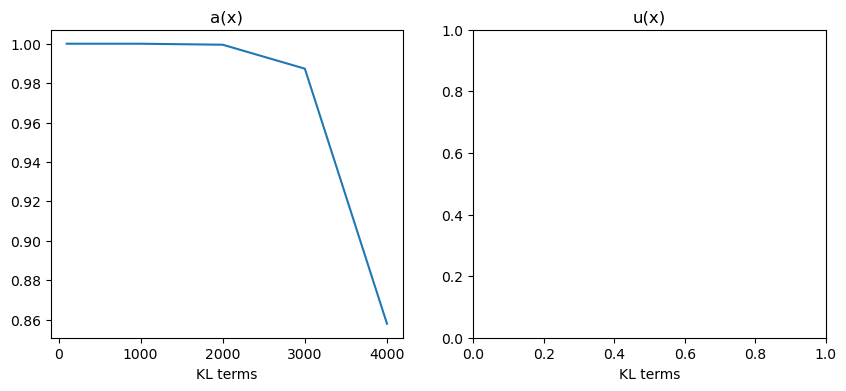

In [30]:
fig, axs = plt.subplots(1,2,figsize = (10,4))

axs[0].plot(sum_elements[:-1],error_sol["coef"])
#axs[1].plot(sum_elements[:-1],error_sol["sol"])

axs[0].set_title(f"a(x)"), axs[1].set_title("u(x)")
axs[0].set_xlabel("KL terms"),axs[1].set_xlabel("KL terms")

In [11]:
X = np.linspace(0, 1, 128)  # Spatial grid in X direction
Y = np.linspace(0, 1, 128)  # Spatial grid in Y direction
X, Y = np.meshgrid(X, Y)  # Create meshgrid for X, Y
n_samples = 1  # Number of samples you want to generate
seed = 0  # Base seed for reproducibility
N_KL = 70

l =0.25
mean =7
solution_list= []
error_sol = []
theta = rng.uniform(low = -np.sqrt(3),high = np.sqrt(3),size=N_KL)

for ncell in range(10,500,10):
    solver = Elliptic2D(theta=theta,ncells=ncell)
    solver.solve()

    points = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)

    u_values =  solver.evaluate_at_points(points)

    z_pred = griddata((X.reshape(-1), Y.reshape(-1)), u_values.flatten(),(X, Y), method='cubic')

    solution_list.append(z_pred)


relterm = np.linalg.norm(solution_list[-1],ord = 2)
for i in range(len(solution_list)):
    error_sol.append(np.linalg.norm(solution_list[-1] - solution_list[i],ord=2)/relterm)

Text(0, 0.5, 'Relative-Error')

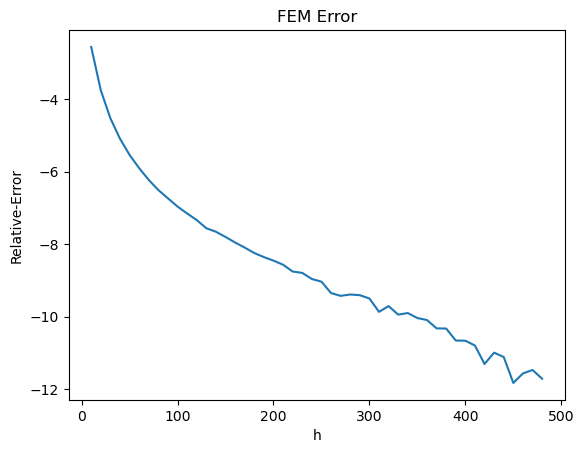

In [12]:
plt.plot(range(10,500,10),np.log(error_sol))
plt.title("FEM Error")
plt.xlabel("h")
plt.ylabel("Relative-Error")
#plt.ylim((0,5e-3))

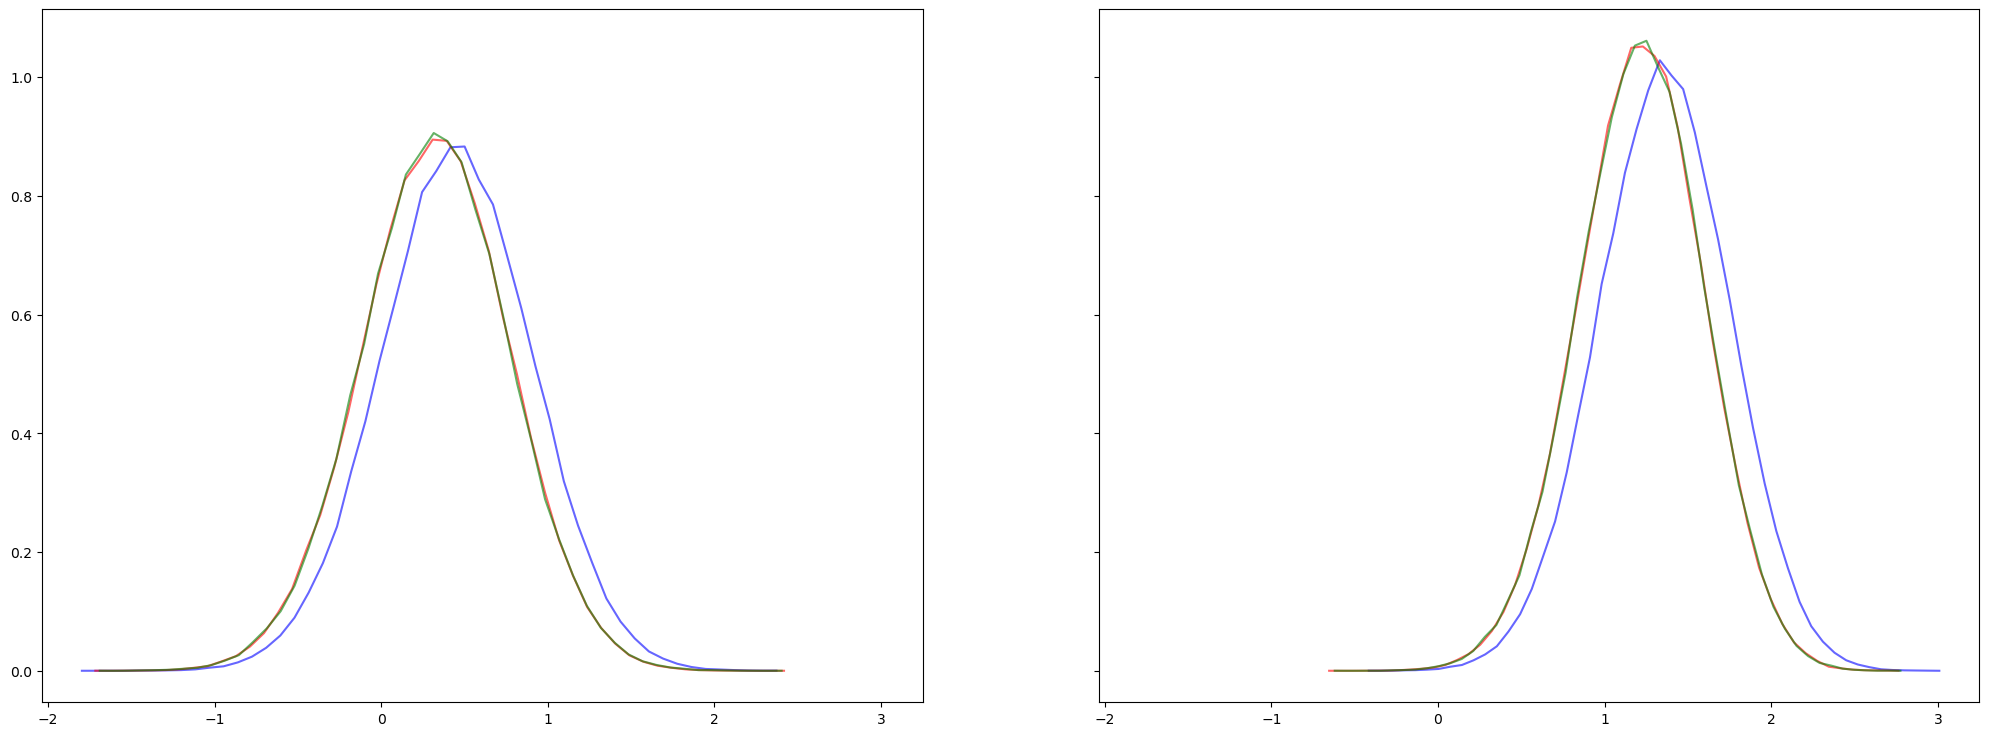

In [4]:
fig, axs = plt.subplots(1,2, figsize=(25, 9), sharey="row", sharex="row")
bins = 50

sample = np.load(f'./results/e2dFEM_kl2_var0.0001_h10.npy')

bin_centers, counts = histogram_(sample[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")

sample = np.load(f'./results/e2dFEM_kl2_var0.0001_h50.npy')

bin_centers, counts = histogram_(sample[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "red")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "red")


sample = np.load(f'./results/e2dFEM_kl2_var0.0001_h100.npy')

bin_centers, counts = histogram_(sample[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "green")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "green")
